# Kernelized Support Vector Machine

## SVM

In [70]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

Text(0,0.5,'Feature 1')

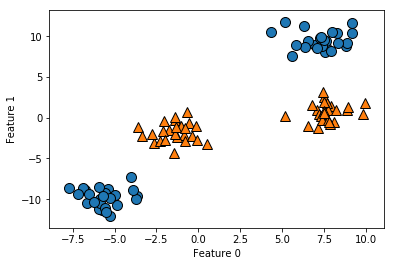

In [11]:
X,y = sklearn.datasets.make_blobs(centers=4, random_state=8)
y=y%2
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0,0.5,'Feature 1')

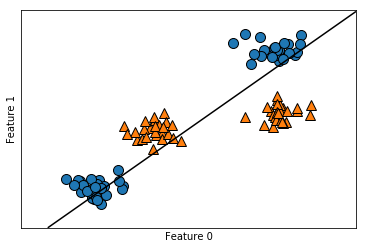

In [15]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X,y)

mglearn.plots.plot_2d_separator(linear_svm,X)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Add a new feature feature1**2

Text(0.5,0,'feature1**2')

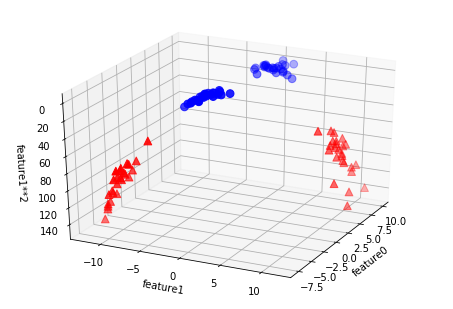

In [33]:
# add the squared first feature

X_new = np.hstack([X,X[:,1:]**2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D

ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y==0, then all with y==1
mask = y==1
ax.scatter(X_new[mask,0], X_new[mask,1], X_new[mask,2], c="b", cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask,0], X_new[~mask,1],X_new[~mask,2], c="r", marker="^", cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1**2")


In the new representation of the data, it is now indeed possible to separate the two classes using a linear model, a planein three dimensions. We can confirm this by fitting a linear model to the augmented data.


Text(0.5,0,'feature1**2')

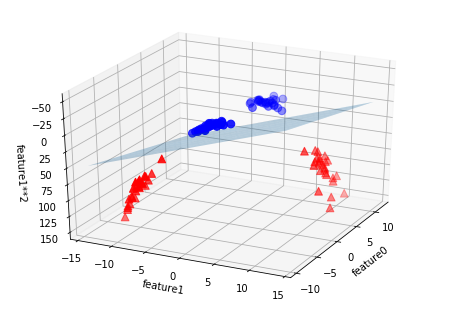

In [44]:
linear_svm_3d = LinearSVC().fit(X_new,y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boubdary

figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:,0].min()-2, X_new[:,0].max()+2, 50)
yy = np.linspace(X_new[:,1].min()-2, X_new[:,1].max()+2, 50)

XX, YY = np.meshgrid(xx,yy)
ZZ = (coef[0]*XX+coef[1]*YY+intercept)/-coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask,0], X_new[mask,1], X_new[mask,2], c="b", cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask,0], X_new[~mask,1],X_new[~mask,2], c="r", marker="^", cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1**2")


As a fuction of the original features, the linear SVM model is not actually linear anymore. It is not a line, but  more of an ellipse, as you can see from the plot created here.

Text(0,0.5,'Feature 1')

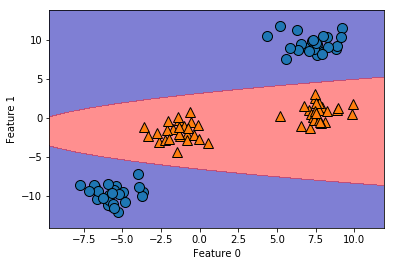

In [45]:
ZZ = YY**2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(),ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(),0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:,0], X[:,1],y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

**The kernel trick**

** understanding SVMs**

The sistance between dat points is measured by the Gaussian kernel
$$k_{rbf}(x_1,x_2) = \exp(\gamma||x_1-x_2||^2)$$

Text(0,0.5,'Feature 1')

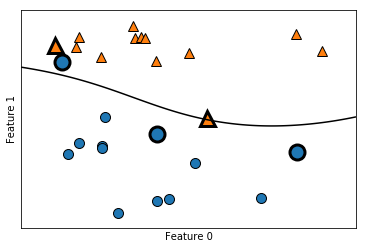

In [54]:
from sklearn.svm import SVC
X,y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X,y)
mglearn.plots.plot_2d_separator(svm,X,eps=.5)
mglearn.discrete_scatter(X[:,0],X[:,1],y)

# plot support vectors
sv = svm.support_vectors_
sv_labels = svm.dual_coef_.ravel()>0
mglearn.discrete_scatter(sv[:,0], sv[:,1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")


## Tuning SVM parameters

Two parameters
 * $\gamma$ - determines the scale of what it means for points to be close together. Large $\gamma$ means complex model.
 * C parameter - a regularization parameter. large C leads to more comples model.

Let's have a look at what happens when we vary these parameters

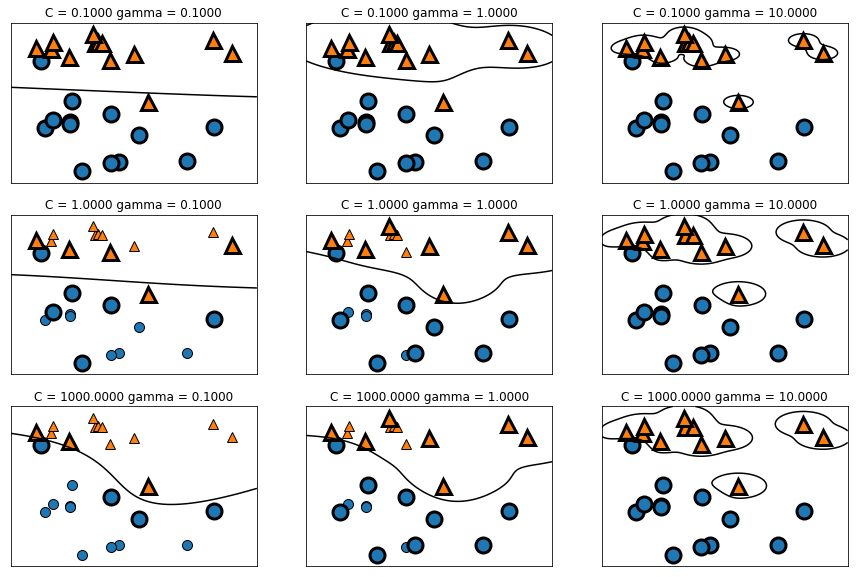

In [64]:
fig, axes = plt.subplots(3,3, figsize=(15,10))

for ax, C in zip(axes,[-1,0,3]):
    for a, gamma in zip(ax, range(-1,2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
#axes[0,0].legend(["class 0", "class 1", "sv class 0", "sv class 1", ncol=4, loc(0.9, 1.2)])

## Consider Breast Cancer dataset

In [75]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train,y_train)

print("Accuracy on training set: {:,.2f}".format(svc.score(X_train,y_train)))
print("Accuracy on test set: {:,.2f}".format(svc.score(X_test,y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


The model overfits quite substantially, with a perfect score on the training set and only 63%  accuracy on the test set. While SVMs often performs well, they are very sensitive to the setting of the parameters and to the scaling of the data. In particular, they require all the features to vary on a similary scale. Let's look at the minimuma and maximum values for each feature, plotted in log-space.

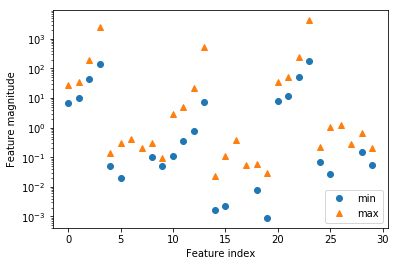

In [76]:
plt.plot(X_train.min(axis=0),'o',label="min")
plt.plot(X_train.max(axis=0),'^',label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

From this plot we can determine that features in the Breast Cancer dataset are of completerly different orders of magnitude. This can be somewhat of a problem for other models (like linear models), but it has devasting effects for the SVM. Let's examine some ways to deal with this issue.

## Pereparing data for SVM

### Method 1
 * Rescale each feature so that they are all approximately on the same scale -> [0,1]

In [82]:
# compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)

# compute the range of each feature (max-min) on the training set
range_on_training = (X_train-min_on_training).max(axis=0)

# substract the min, and divide by range
# afterward, min=0 and mizx=1 for each feature
X_train_scaled  = (X_train - min_on_training)/range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n{}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Maximum for each feature
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [85]:
# use the same transformation on the test set
# using min and range of the training set (see Chapter 3 for detail)
X_test_scaled = (X_test-min_on_training)/range_on_training

svc = SVC()
svc.fit(X_train_scaled,y_train)
print("Accuracy on training set: {:,.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:,.3f}".format(svc.score(X_test_scaled,y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


Now we are actually in a underfitting regime. We can try increasing C or gamma to fit a more complex model.

In [86]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:,.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:,.3f}".format(svc.score(X_test_scaled,y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


## SVM Strengths, weaknesses, and parameters

**Strengths**
 * allows for complex decision boundaries, even if the data has only a few features
 * works well on low-dimensional and high-dimensional data

**Weekness**
 * SVM does not scale well with the number of samples. Running SVM with up to 10,000 samples might work well,  but working with datasets of size 100,000 or more can become challenging in terms of run tie and memory usage.
 * Need careful preprocessing data and runing of the parameters.
 * difficult to understand why a particular prediction as made
 * tricky to explain the model to a nonexpert
 
That is why most people instead use tree-base models such as random forests or gradient boosting (which require little or no preprocessing). I t might be worth trying SVMs.